In [ ]:
%%time
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re
import nltk
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from keras import models
from keras import layers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

CPU times: user 5.22 s, sys: 851 ms, total: 6.07 s
Wall time: 15.5 s


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

train_filename = "/content/drive/MyDrive/Punny_Punctuators/DravidianLangTech@EACL_2024/Task_1/Fake_train.csv"
val_filename = "/content/drive/MyDrive/Punny_Punctuators/DravidianLangTech@EACL_2024/Task_1/Fake_dev.csv"
test_filename = "/content/drive/MyDrive/Punny_Punctuators/DravidianLangTech@EACL_2024/Task_1/Fake_test_without_labels.csv"


train_data = pd.read_csv(train_filename)
validation_data = pd.read_csv(val_filename)
test = pd.read_csv(test_filename)


In [ ]:
print("Size of the training data ==> ", train_data.shape)
print("Size of the validation data ==>", validation_data.shape)

Size of the training data ==>  (3257, 2)
Size of the validation data ==> (815, 2)


In [ ]:
## Mapping the labels original=0, Fake=1
train_data['training_label']= train_data.label.replace({'original':0,'Fake':1})
print(train_data.head(10))

                                                text     label  training_label
0                  നല്ല അവതരണം. സത്യം പുറത്തു വരട്ടെ      Fake               1
1                                        Masha Allah      Fake               1
2  അന്വേഷണം കഴിയുമ്പോൾ,. C. A. A. യ്ക്ക് എതിരായ ക...      Fake               1
3    Illathentha avaru purath vidayittalland verenth      Fake               1
4  Barana pakshathin matoru niyamam.nalla moyanth...  original               0
5  Marunnu adyam kandupidichittey virous kandupid...      Fake               1
6  Sudappikal Naadu mudikkum. Moorikallkk eandhu ...      Fake               1
7                              നാണമുണ്ടോ ഗവണ്മെന്റെ?  original               0
8  Aaayur Veathana an Oru vitamin Aaalugal Sareer...      Fake               1
9  😂😂😂😂😂😂patt sakhavine pokki parayuano atho trol...  original               0


In [ ]:
validation_data['validation_label']= validation_data.label.replace({'original':0,'Fake':1})
validation_data.head(10)

,text,label,validation_label
0,Full. Musilm. Verodamum,Fake,1
1,പക്ഷികളും മൃഗങ്ങളും ഈ ലോകത്ത് സുഖമായി ജീവിക്കു...,Fake,1
2,ഒരു താടിക്കാരൻ പാത്രം കൊട്ടാൻ പറഞ്ഞപ്പോ .........,original,0
3,കുംഭളേമ<br>മറന്നോ,original,0
4,ഇത് തിരുവാതിര അല്ല...... കോറോണയെ കൈകൊട്ടി കൊല്...,original,0
5,Kejriwal failed to control these people.,Fake,1
6,അനുഭവിച്ചോളി അവന്മാരുടെ ഒടുക്കത്തെ കളി ഇതൊക്കെ...,original,0
7,Climax polichuu....🤣🤣,original,0
8,ഈ സംഗീതത്തിന് ഈ വർഷത്തെ അവാർഡ് ഉറപ്പ്.!!😢,original,0
9,ആരും അടിവര ഇടാതെ തന്നെ വിവരമുള്ളവർക് അറിയാം കമ...,Fake,1


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
%%time
## Cleaning the data. Removing newlines, unnecessary symbols

punctuations = '''’'!()-[]{};:'"\,<>./?@#$%^&*_~�'''



def remove_punctuation_url(d):
    d=d.lower()
    d = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', d, flags=re.MULTILINE) #This line is for removing url
    review = d.replace('\n', '')
    no_punct = ""
    for char in review:
      if char not in punctuations:
         no_punct = no_punct + char
    return no_punct

def remove_stopwords(d):
  text_tokens = word_tokenize(d.lower())
  tokens_without_sw = [word for word in text_tokens if not word in stopwords.words('english')]
  ls = ""
  for w in tokens_without_sw:
    ls = ls +" "+w.lower()
  return ls

#removing URLs and Punctuations
#train_data['cleaned'] = train_data['tweet'].apply(remove_url)
#Removing punctuations
train_data['cleaned'] = train_data['text'].apply(remove_punctuation_url)
validation_data['cleaned'] = validation_data['text'].apply(remove_punctuation_url)
#Removing stop words
#train_data['cleaned'] = train_data['cleaned'].apply(remove_stopwords)

## Data samples after cleaning
print("Data samples after cleaning:\n")
for i in range(10):
  print(train_data.cleaned[i])

NameError: ignored

In [ ]:
%%time
## Cleaning the data. Removing newlines, unnecessary symbols

punctuations = '''’'!()-[]{};:'"\,<>./?@#$%^&*_~�'''



def remove_punctuation_url(d):
    d=d.lower()
    d = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', d, flags=re.MULTILINE) #This line is for removing url
    review = d.replace('\n', '')
    no_punct = ""
    for char in review:
      if char not in punctuations:
         no_punct = no_punct + char
    return no_punct

def remove_stopwords(d):
  text_tokens = word_tokenize(d.lower())
  tokens_without_sw = [word for word in text_tokens if not word in stopwords.words('malayalam')]
  ls = ""
  for w in tokens_without_sw:
    ls = ls +" "+w.lower()
  return ls

#removing URLs and Punctuations
#train_data['cleaned'] = train_data['tweet'].apply(remove_url)
#Removing punctuations
train_data['cleaned'] = train_data['text'].apply(remove_punctuation_url)
validation_data['cleaned'] = validation_data['text'].apply(remove_punctuation_url)
#Removing stop words
#train_data['cleaned'] = train_data['cleaned'].apply(remove_stopwords)

## Data samples after cleaning
print("Data samples after cleaning:\n")
for i in range(10):
  print(train_data.cleaned[i])

Data samples after cleaning:

നല്ല അവതരണം സത്യം പുറത്തു വരട്ടെ
masha allah
അന്വേഷണം കഴിയുമ്പോൾ c a a യ്ക്ക് എതിരായ കലാപം പോലെ ആകുമോ സ്വന്തം ആളെ തന്നെ പിടിച്ചു അകത്തിടേണ്ടി വരുമോ
illathentha avaru purath vidayittalland verenth
barana pakshathin matoru niyamamnalla moyanth manthrii
marunnu adyam kandupidichittey virous kandupidikkullu china
sudappikal naadu mudikkum moorikallkk eandhu rajiyasneham 😡
നാണമുണ്ടോ ഗവണ്മെന്റെ
aaayur veathana an oru vitamin aaalugal sareerathin keadillaathea kayikkunnath roagam maarunnumund butbreee vaythyanmaar parayunnath seriyaanoo annariyoolabronnu pareeksichoodeabraarudea velluvili seegarikkbrkoroanayulla aalugaludea adutheakkbrvid
😂😂😂😂😂😂patt sakhavine pokki parayuano atho trolluvano
CPU times: user 167 ms, sys: 3.7 ms, total: 171 ms
Wall time: 179 ms


In [ ]:
import nltk
from nltk.corpus import stopwords

In [ ]:
stops = set(stopwords.words('english'))

def cleantext(string):
    text = string.lower().split()
    text = " ".join(text)
    text = re.sub(r"http(\S)+",' ',text)
    text = re.sub(r"www(\S)+",' ',text)
    text = re.sub(r"&",' and ',text)
    tx = text.replace('&amp',' ')
    #text = re.sub(r"[^0-9a-zA-Z]+",' ',text)
    text = text.split()
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    text = re.sub(r"[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+", ' ', text)

    return text

In [ ]:
import re

def remove_html_tags(text):
    cleaned_text = re.sub(r'<.*?>', '', text)
    return cleaned_text


In [ ]:
train_data['cleaned'] = train_data['text'].map(lambda x: cleantext(x))
train_data['cleaned'] = train_data['cleaned'].apply(remove_html_tags)

validation_data['cleaned'] = validation_data['text'].map(lambda x: cleantext(x))
validation_data['cleaned'] = validation_data['cleaned'].apply(remove_html_tags)

test['cleaned'] = test['text'].map(lambda x: cleantext(x))
test['cleaned'] = test['cleaned'].apply(remove_html_tags)

In [ ]:
train_data.head(10)


,text,label,training_label,cleaned
0,നല്ല അവതരണം. സത്യം പുറത്തു വരട്ടെ,Fake,1,നല്ല അവതരണം. സത്യം പുറത്തു വരട്ടെ
1,Masha Allah,Fake,1,masha allah
2,"അന്വേഷണം കഴിയുമ്പോൾ,. C. A. A. യ്ക്ക് എതിരായ ക...",Fake,1,"അന്വേഷണം കഴിയുമ്പോൾ,. c. a. a. യ്ക്ക് എതിരായ ക..."
3,Illathentha avaru purath vidayittalland verenth,Fake,1,illathentha avaru purath vidayittalland verenth
4,Barana pakshathin matoru niyamam.nalla moyanth...,original,0,barana pakshathin matoru niyamam.nalla moyanth...
5,Marunnu adyam kandupidichittey virous kandupid...,Fake,1,marunnu adyam kandupidichittey virous kandupid...
6,Sudappikal Naadu mudikkum. Moorikallkk eandhu ...,Fake,1,sudappikal naadu mudikkum. moorikallkk eandhu ...
7,നാണമുണ്ടോ ഗവണ്മെന്റെ?,original,0,നാണമുണ്ടോ ഗവണ്മെന്റെ?
8,Aaayur Veathana an Oru vitamin Aaalugal Sareer...,Fake,1,aaayur veathana oru vitamin aaalugal sareerath...
9,😂😂😂😂😂😂patt sakhavine pokki parayuano atho trol...,original,0,patt sakhavine pokki parayuano atho trolluvano


In [ ]:
!pip install datasets transformers[sentencepiece]
!pip install sentencepiece

In [ ]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

MODEL_TYPE = 'xlm-roberta-base'

tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_TYPE, do_lower_case=True)

In [ ]:
!pip install ai4bharat-transliteration

In [ ]:
from ai4bharat.transliteration import XlitEngine

e = XlitEngine("ml", beam_width=10)

def transliteration(text):
    out = e.translit_sentence(text)
    return out["ml"]

Initializing Multilingual model for transliteration


Loading dicts into RAM: 100%|██████████| 1/1 [00:41<00:00, 41.40s/it]


In [ ]:
!pip install tqdm
from tqdm import tqdm
tqdm.pandas(desc='Back Translation') ## For viewwing progress

In [ ]:
train_data['transliterated_text'] = train_data['cleaned'].progress_apply(transliteration)
train_data.to_csv('/content/drive/MyDrive/Punny_Punctuators/DravidianLangTech@EACL_2024/Task_1/transliterated.csv')

Back Translation: 100%|██████████| 3257/3257 [23:01<00:00,  2.36it/s]


In [ ]:
train_data.sample(10)

,text,label,training_label,cleaned,transliterated_text
2829,എന്തുവാ സഖാവേ അമ്മായിക്കും അടുപ്പിലും ആവാം 🤔🤔,original,0,എന്തുവാ സഖാവേ അമ്മായിക്കും അടുപ്പിലും ആവാം,എന്തുവാ സഖാവേ അമ്മായിക്കും അടുപ്പിലും ആവാം
134,"Evanmar orikalum sathyam parayilla, live recor...",Fake,1,"evanmar orikalum sathyam parayilla, live recor...","ഇവന്മാർ ഒരികളും സത്യം പറയില്ല, ലൈവ് റെക്കോർഡ് ..."
2299,ഇതിലും വെല്യേ ഒരു ട്രോൾ ഉണ്ടോ 🤣🤣<br>അവതാരകന് എ...,original,0,ഇതിലും വെല്യേ ഒരു ട്രോൾ ഉണ്ടോ അവതാരകന് എത്ര ക...,ഇതിലും വെല്യേ ഒരു ട്രോൾ ഉണ്ടോ അവതാരകന് എത്ര ക...
1610,paranarikal.....,original,0,paranarikal.....,പരനറികൾ.....
990,കഷ്ടം.....,original,0,കഷ്ടം.....,കഷ്ടം.....
1173,Appol China undakki vitta virus ano ee corona,Fake,1,appol china undakki vitta virus ano ee corona,അപ്പോൾ ചിന ഉണ്ടാക്കി വിട്ട വൈറസ് അനോ ഇഇ കൊറോണ
1206,ah poyitto,Fake,1,ah poyitto,അഹ് പോയിട്ടോ
1869,ഇത് വെറും സാമ്പിള് വെടി കെട്ടു മാത്രം .,Fake,1,ഇത് വെറും സാമ്പിള് വെടി കെട്ടു മാത്രം .,ഇത് വെറും സാമ്പിള് വെടി കെട്ടു മാത്രം .
2986,Pakisthan is also their close friends group an...,Fake,1,pakisthan also close friends group affected gr...,പാകിസ്ഥാൻ അൽസോ ക്ലോസ് ഫ്രണ്ട്സ് ഗ്രൂപ്പ് അഫക്ട...
2668,സിപിഎം ന്റെ കൂടെ കൂടി വീണക്കും ബുന്ദി പോയി എന്...,original,0,സിപിഎം ന്റെ കൂടെ കൂടി വീണക്കും ബുന്ദി പോയി എന്...,സിപിഎം ന്റെ കൂടെ കൂടി വീണക്കും ബുന്ദി പോയി എന്...


In [ ]:
validation_data['transliterated_text'] = validation_data['cleaned'].progress_apply(transliteration)
validation_data.to_csv('/content/drive/MyDrive/Punny_Punctuators/DravidianLangTech@EACL_2024/Task_1/validation_transliterated.csv')

Back Translation: 100%|██████████| 815/815 [06:21<00:00,  2.13it/s]


In [ ]:
validation_data.sample(10)

,text,label,validation_label,cleaned,transliterated_text
196,"Ithoru puthiya number, a new game !!!",Fake,1,"ithoru puthiya number, new game !!!","ഇതൊരു പുതിയ നമ്പർ, ന്യൂ ഗെയിം !!!"
299,Fine ennum parachu vaa,original,0,fine ennum parachu vaa,ഫൈൻ എന്നും പറച്ചു വാ
388,ee kuthira kali kaselayil irikyumbol mathrame ...,original,0,ee kuthira kali kaselayil irikyumbol mathrame ...,ഇഇ കുതിര കളി കസേലയിൽ ഇരിക്യുമ്പോൾ മാത്രമേ പറ്റ...
227,Vrithiketta bharanam,original,0,vrithiketta bharanam,വൃത്തികെട്ട ഭരണം
664,Le ഷം ഉള്ളുപ്പ്,original,0,le ഷം ഉള്ളുപ്പ്,ലെ ഷം ഉള്ളുപ്പ്
801,I support vidyar and jacob ji,Fake,1,support vidyar jacob ji,സപ്പോർട്ട് വിദ്യാർ ജേക്കബ് ജി
199,E commikal mushuvanum ingane aano,original,0,e commikal mushuvanum ingane aano,ഇ കമ്മികൾ മുശുവനും ഇങ്ങനെ ആണോ
336,കുമ്പ മേള ഒരു വർഷം മാറ്റി വെച്ചാൽ ആകാശം ഇടിയ...,Fake,1,കുമ്പ മേള ഒരു വർഷം മാറ്റി വെച്ചാൽ ആകാശം ഇടിയുമോ..,കുമ്പ മേള ഒരു വർഷം മാറ്റി വെച്ചാൽ ആകാശം ഇടിയുമോ..
338,"Allopathy hasn&#39;t any medicine, then why th...",Fake,1,"allopathy #39;t medicine, stupidity","അലോപ്പതി #൩൯;ട് മെഡിസിൻ, സ്റ്റുപിഡിറ്റി"
528,പോടനായെ,original,0,പോടനായെ,പോടനായെ


In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/Punny_Punctuators/DravidianLangTech@EACL_2024/Task_1/Fake_test_without_labels.csv', delimiter=',', header=0)
test_data['cleaned'] = test_data['text'].apply(remove_punctuation_url)

test_data['transliterated_text'] = test_data['cleaned'].progress_apply(transliteration)
test_data.to_csv('/content/drive/MyDrive/Punny_Punctuators/DravidianLangTech@EACL_2024/Task_1/test_transliterated.csv')

Back Translation: 100%|██████████| 1019/1019 [08:14<00:00,  2.06it/s]


In [ ]:
test_data.sample(10)

,text,cleaned,transliterated_text
522,China chatiyanmaranu avanmar indaki vitatha it...,china chatiyanmaranu avanmar indaki vitatha it...,ചിന ചതിയന്മാരാണ് അവന്മാർ ഇന്ദകി വിറ്റത ഇട്ടു അ...
453,മനോരമയെ സമ്മതിച്ചു. 🙏 നൈസ് ആയിട്ട് ആളുകളെ .......,മനോരമയെ സമ്മതിച്ചു 🙏 നൈസ് ആയിട്ട് ആളുകളെ ഇതിൽ...,മനോരമയെ സമ്മതിച്ചു 🙏 നൈസ് ആയിട്ട് ആളുകളെ ഇതിൽ...
439,എന്ത് പറഞ്ഞിട്ട് കാര്യമില്ല ജനങ്ങളെ രക്ഷിക്കാ...,എന്ത് പറഞ്ഞിട്ട് കാര്യമില്ല ജനങ്ങളെ രക്ഷിക്കാ...,എന്ത് പറഞ്ഞിട്ട് കാര്യമില്ല ജനങ്ങളെ രക്ഷിക്കാ...
31,"Communists 😜 have to wear mask , why to enjoy ...",communists 😜 have to wear mask why to enjoy m...,കമ്യൂണിസ്റ്റ്സ് 😜 ഹേവ് ടോ വിയർ മാസ്ക് വൈ ടോ എ...
615,Arenkilum pedippicho🤔🤔🤔,arenkilum pedippicho🤔🤔🤔,ആരെങ്കിലും പേടിപ്പിച്ചോ🤔🤔🤔
584,നാണമില്ലാത്ത വർഗ്ഗം ത്ഫൂ,നാണമില്ലാത്ത വർഗ്ഗം ത്ഫൂ,നാണമില്ലാത്ത വർഗ്ഗം ത്ഫൂ
442,കൊറോണയെകാളും വലിയ വൈറസ് ഇവിടെ ഉണ്ട്,കൊറോണയെകാളും വലിയ വൈറസ് ഇവിടെ ഉണ്ട്,കൊറോണയെകാളും വലിയ വൈറസ് ഇവിടെ ഉണ്ട്
731,"Ivarkethire paranjal ,paranjavar sangikal , an...",ivarkethire paranjal paranjavar sangikal anub...,ഇവർക്കെതിരെ പറഞ്ഞാൽ പറഞ്ഞവർ സങ്കികൾ അനുഭവം ഗുരു
76,കോറോണയെപ്പറ്റിയറിയാൻ ഇതൊന്നു കണ്ടുനോക്കൂ<br><a...,കോറോണയെപ്പറ്റിയറിയാൻ ഇതൊന്നു കണ്ടുനോക്കൂbra hr...,കോറോണയെപ്പറ്റിയറിയാൻ ഇതൊന്നു കണ്ടുനോക്കൂബ്രാ ഹ...
493,So sad to see traditional used for political c...,so sad to see traditional used for political c...,സോ സാദ് ടോ സി ട്രഡീഷണൽ യൂസ്ഡ് ഫോർ പൊളിറ്റിക്കൽ...


In [ ]:
def data_statistics(class_names):
  words_per_class = []
  unique_words_per_class = []
  documents_per_class = []

  for label in class_names:
    ## Word list from the clean dataset
    word_list = [word.strip().lower() for t in list(train_data[train_data.label==label].cleaned) for word in t.strip().split()]
    counts = dict()
    for w in word_list:
      counts[w] = counts.get(w, 0)+1
    # Sort the word list on descending order in terms of frequency
    ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    # Total words per class
    words_per_class.append(len(word_list))
    # Unique words per class
    unique_words_per_class.append(len(np.unique(word_list)))
    # Number of documents per class
    documents_per_class.append(len(list(train_data[train_data.label==label].cleaned)))

    print("Class name: {}".format(label))
    print("Number of words: {}".format(len(word_list)))
    print("Number of unique words: {}".format(len(np.unique(word_list))))
    print("Number of Documents: {}".format(len(list(train_data[train_data.label==label].cleaned))))
    print("10 most frequent words:\n")
    for i, f in ordered[:10]:
      print("{}\t{}".format(i, f))

  return words_per_class, unique_words_per_class, documents_per_class

class_names = ['original','Fake']

words, unique_words, documents = data_statistics(class_names)

Class name: original
Number of words: 13268
Number of unique words: 7541
Number of Documents: 1658
10 most frequent words:

ഒരു	149
ഈ	103
തിരുവാതിര	101
പാർട്ടി	63
എന്ന്	53
പിണറായി	45
ആണ്	43
കേരളം	42
തന്നെ	41
oru	36
Class name: Fake
Number of words: 21420
Number of unique words: 12418
Number of Documents: 1599
10 most frequent words:

ഒരു	212
ഈ	125
china	107
ചൈന	103
കൊറോണ	92
എന്ന്	76
corona	76
.	73
തന്നെ	70
അത്	65


In [ ]:

data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':unique_words,
                            'Class Names':class_names})
data_matrix

,Total Documents,Total Words,Unique Words,Class Names
0,1658,13268,7541,original
1,1599,21420,12418,Fake


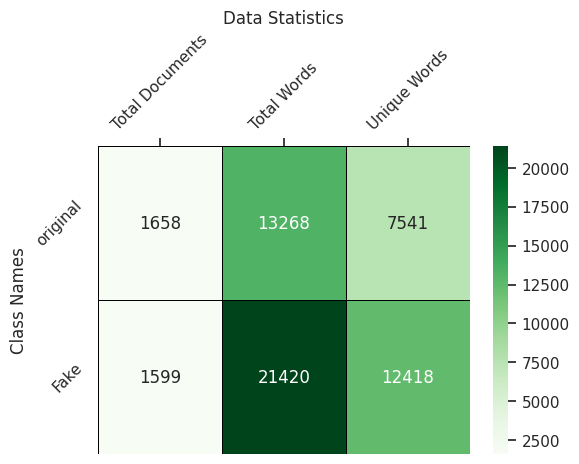

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
plt.figure(figsize =(6, 4))
ax = plt.subplot()
sns.heatmap(data_matrix.iloc[:,0:3], annot=True,fmt="d", linewidths=0.5,linecolor = 'Black',cmap = 'Greens',ax = ax) #annot=True to annotate cells
# labels, title and ticks
ax.set_ylabel('Class Names')
ax.set_title('Data Statistics')
y_label = ["Total Documents", "Total Words", "Unique Words"]
ax.xaxis.set_ticklabels(y_label, rotation=45); ax.yaxis.set_ticklabels(class_names, rotation=45);
ax.xaxis.tick_top()

In [ ]:
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")
print(df)

  Class Names         Category  Values
0    original  Total Documents    1658
1        Fake  Total Documents    1599
2    original      Total Words   13268
3        Fake      Total Words   21420
4    original     Unique Words    7541
5        Fake     Unique Words   12418


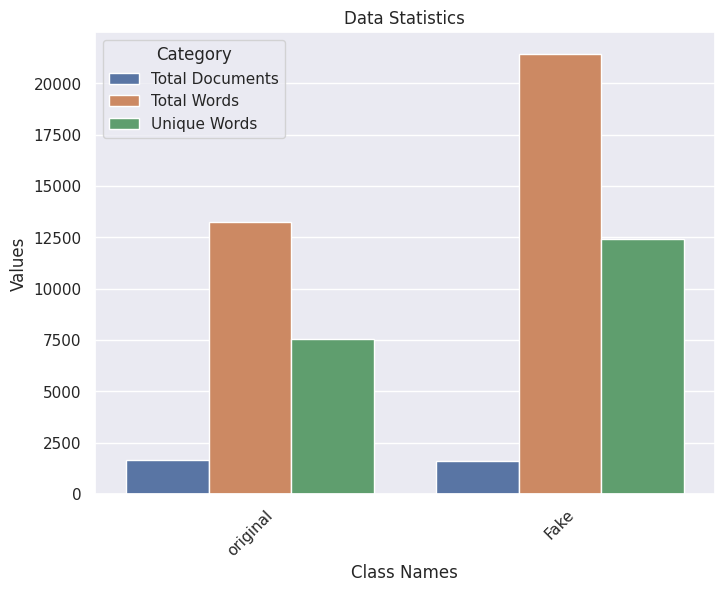

In [ ]:
plt.figure(figsize=(8, 6))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names')
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

In [ ]:
frequency = dict()
for x in train_data['cleaned']:
  i = len(x.split())
  frequency[i] = frequency.get(i, 0)+1
frequency = sorted(frequency.items(), key= lambda item: item[0])
print(frequency)
print(type(frequency))

[(0, 2), (1, 171), (2, 328), (3, 285), (4, 293), (5, 286), (6, 247), (7, 231), (8, 188), (9, 129), (10, 138), (11, 107), (12, 84), (13, 68), (14, 74), (15, 60), (16, 47), (17, 51), (18, 35), (19, 24), (20, 38), (21, 37), (22, 28), (23, 13), (24, 14), (25, 20), (26, 15), (27, 18), (28, 13), (29, 14), (30, 16), (31, 13), (32, 10), (33, 11), (34, 10), (35, 9), (36, 4), (37, 11), (38, 12), (39, 8), (40, 4), (41, 4), (42, 4), (43, 4), (44, 2), (45, 2), (46, 1), (47, 4), (48, 4), (49, 3), (50, 6), (51, 1), (52, 4), (53, 2), (54, 1), (55, 1), (56, 3), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (63, 2), (64, 2), (65, 1), (66, 2), (68, 2), (70, 2), (71, 1), (80, 1), (82, 2), (85, 1), (86, 3), (90, 1), (91, 1), (95, 1), (97, 2), (100, 1), (103, 1), (104, 1), (107, 2), (109, 1), (115, 1), (118, 1), (127, 1), (149, 1), (154, 1), (173, 2), (263, 1), (329, 1), (338, 1)]
<class 'list'>


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 68, 70, 71, 80, 82, 85, 86, 90, 91, 95, 97, 100, 103, 104, 107, 109, 115, 118, 127, 149, 154, 173, 263, 329, 338] [2, 171, 328, 285, 293, 286, 247, 231, 188, 129, 138, 107, 84, 68, 74, 60, 47, 51, 35, 24, 38, 37, 28, 13, 14, 20, 15, 18, 13, 14, 16, 13, 10, 11, 10, 9, 4, 11, 12, 8, 4, 4, 4, 4, 2, 2, 1, 4, 4, 3, 6, 1, 4, 2, 1, 1, 3, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1]


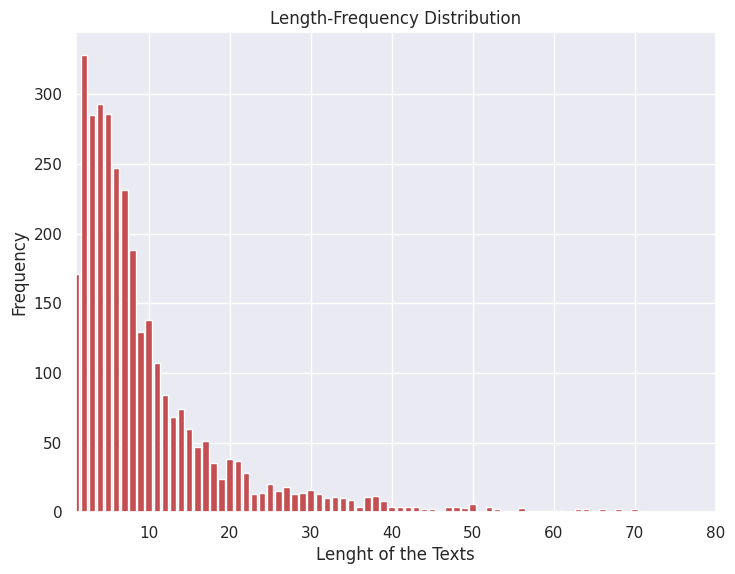

In [ ]:
xx = [x for x, k in frequency]
yy = [k for x, k in frequency]
print(xx, yy)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(xx,yy, color='r')
plt.xlim(1, 80)

plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

def text_encoding(texts, labels, max_words, padding_length):
  tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n-',
                      split=' ', char_level=False, oov_token=None, document_count=0)

  # Tokenizer is fitted into the texts
  tokenizer.fit_on_texts(texts)

  # Printing tokenizer information
  (word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)

  def tokenizer_info(mylist):
    ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = True)
    for w,c in ordered[:10]:
      print(w,"\t",c)

  print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)
  print("Words --> Counts:")
  tokenizer_info(word_counts)
  print("\nWords --> Documents:")
  tokenizer_info(word_docs)
  print("\nWords --> Index:")
  tokenizer_info(word_index)
  print("\nTotal Documents -->",document_count)

  # Encoding texts into integer sequences
  sequences = tokenizer.texts_to_sequences(texts)
  word_index = tokenizer.word_index
  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\nFound {} unique tokens".format(len(word_index)))
  print(texts[10],"\n",sequences[10])

  # Pad sequences
  corpus = keras.preprocessing.sequence.pad_sequences(sequences, value=0.0,
                                                      padding='post', maxlen= padding_length)
  print("\n\t\t\t====== Paded Sequences ======\n",texts[10],"\n",corpus[10])

  return corpus, labels, tokenizer

##
max_words = 20000# Based on number of unique words in the dataset
padding_length = 100

corpus, labels, tokenizer = text_encoding(train_data.cleaned, train_data.training_label, max_words, padding_length)

			====== Tokenizer Info ======
Words --> Counts:
br 	 674
ഒരു 	 368
ഈ 	 247
എന്ന് 	 146
കൊറോണ 	 144
ആണ് 	 139
തന്നെ 	 134
china 	 133
തിരുവാതിര 	 117
ചൈന 	 117

Words --> Documents:
ഒരു 	 290
br 	 252
ഈ 	 198
എന്ന് 	 127
കൊറോണ 	 127
ആണ് 	 124
തന്നെ 	 116
തിരുവാതിര 	 110
china 	 100
ചൈന 	 95

Words --> Index:
acting 	 16694
കളിപ്പിച്ച് 	 16693
സോപ്പിട്ട് 	 16692
എല്ലാത്തിനേം 	 16691
പ്രഹസനവുമാണ് 	 16690
മോശവും 	 16689
അതുമതി 	 16688
ഇല്ലാത്തവരുമായ 	 16687
ശെരിവെക്കുന്ന 	 16686
ആശയങ്ങൾ 	 16685

Total Documents --> 3257

			====== Encoded Sequences ====== 
Found 16694 unique tokens
ഖുർആൻ നിൽ ഉണ്ടാവും അതിന്റ മരുന്ന് വായിച്ചു നോക്കിയാൽ മതി. 
 [4398, 4399, 1517, 2270, 103, 4400, 1518, 86]

			====== Paded Sequences ======
 ഖുർആൻ നിൽ ഉണ്ടാവും അതിന്റ മരുന്ന് വായിച്ചു നോക്കിയാൽ മതി. 
 [4398 4399 1517 2270  103 4400 1518   86    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0

In [ ]:
training_data, training_labels = corpus, labels


In [ ]:
print(training_data, training_labels)


[[   27   246    85 ...     0     0     0]
 [ 4354  1512     0 ...     0     0     0]
 [ 4355  1129  1513 ...     0     0     0]
 ...
 [  148  4244     0 ...     0     0     0]
 [16691   807 16692 ...     0     0     0]
 [  979   979   448 ...     0     0     0]] 0       1
1       1
2       1
3       1
4       0
       ..
3252    0
3253    0
3254    0
3255    0
3256    0
Name: training_label, Length: 3257, dtype: int64


In [ ]:
## Defining Callbacks
def define_callback():
  keras.backend.clear_session()
  accuracy_threshold = .999

  class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>accuracy_threshold):
          print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
          self.model.stop_training = True

  acc_callback = myCallback()

  return acc_callback

# Define TensorBoard
def define_TensorBoard():
  %load_ext tensorboard
  import datetime, os
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  return tensorboard_callback

# Define Checkpoint
def define_checkpoint():
  filepath = "ModelOnOurData.h5"
  checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, save_weights_only=False, mode='max')
  return checkpoint

In [ ]:
# Create Model
def create_model(embedding_dim):
  keras.backend.clear_session()
  no_of_class = len(class_names)

  model = keras.models.Sequential([
      keras.layers.Embedding(max_words, embedding_dim, input_length = padding_length),
      #keras.layers.Conv1D(64, 5, activation='relu'),
      #keras.layers.MaxPooling1D(5),
      #keras.layers.Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)),
      keras.layers.Bidirectional(LSTM(32, dropout=0.2)),
      keras.layers.Flatten(),
      keras.layers.Dense(no_of_class, activation = 'softmax')
  ])

  model.summary()
  return model

# Visualize Model
def model_visualize(model):
  from tensorflow.keras.utils import plot_model
  plot_model(model, to_file = 'print.png', show_shapes = True, show_layer_names = True)

# Compile Model
def compile_model(model):
  model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy')
  return model

In [ ]:
%%time
## Callbacks are really important

def run_callback_list():
  acc_callback = define_callback()
  checkpoint = define_checkpoint()
  tensorboard_callback = define_TensorBoard()
  return [acc_callback, checkpoint, tensorboard_callback]

callback_list = run_callback_list()

def run_model():
    embedding_dim = 100
    model = create_model(embedding_dim)
    model = compile_model(model)
    model_visualize(model)
    return model

## Create, Compile and Visualize the model
cnn_lstm_model = run_model() ##


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2000000   
                                                                 
 bidirectional (Bidirection  (None, 64)                34048     
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 2034178 (7.76 MB)
Trainable params: 2034178 (7.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
CPU times: user 737 ms, sys: 23.4 ms, total: 761 ms
Wall time: 930 ms


In [ ]:
cnn_lstm_model_history = cnn_lstm_model.fit(training_data,
                              training_labels,
                              epochs = 150,
                              batch_size = 64,
                              verbose = 1,
                              validation_split = 0.10,
                              callbacks = callback_list)

Epoch 1/150
46/46 [==============================] - ETA: 0s - loss: 0.6693 - accuracy: 0.6066
Epoch 1: val_accuracy improved from -inf to 0.61350, saving model to ModelOnOurData.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 15s 223ms/step - loss: 0.6693 - accuracy: 0.6066 - val_loss: 0.6540 - val_accuracy: 0.6135
Epoch 2/150
46/46 [==============================] - ETA: 0s - loss: 0.4431 - accuracy: 0.8250
Epoch 2: val_accuracy improved from 0.61350 to 0.78528, saving model to ModelOnOurData.h5
46/46 [==============================] - 6s 139ms/step - loss: 0.4431 - accuracy: 0.8250 - val_loss: 0.4632 - val_accuracy: 0.7853
Epoch 3/150
46/46 [==============================] - ETA: 0s - loss: 0.1201 - accuracy: 0.9672
Epoch 3: val_accuracy improved from 0.78528 to 0.80061, saving model to ModelOnOurData.h5
46/46 [==============================] - 8s 177ms/step - loss: 0.1201 - accuracy: 0.9672 - val_loss: 0.4582 - val_accuracy: 0.8006
Epoch 4/150
46/46 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9915
Epoch 4: val_accuracy did not improve from 0.80061
46/46 [==============================] - 7s 159ms/step - loss: 0.0425 - accuracy: 0.9915 -

In [ ]:
val_filename = "/content/drive/MyDrive/Punny_Punctuators/DravidianLangTech@EACL_2024/Task_1/Fake_dev.csv"
validation_data = pd.read_csv(val_filename)
print("\n\nSize of the validation data ==> ", len(validation_data))
print(validation_data.head(5))

print(type(validation_data))
print(validation_data.head(10))

validation_data['validation_label']= validation_data.label.replace({'original':0,'Fake':1})

## Cleaning the data. Removing newlines, unnecessary symbols
#validation_data['cleaned'] = validation_data['tweet'].apply(remove_url)
validation_data['cleaned'] = validation_data['text'].apply(remove_punctuation_url)
#data['cleaned'] = data['cleaned'].apply(remove_stopwords)
print(validation_data.head(10))



Size of the validation data ==>  815
                                                text     label
0                         Full.  Musilm.   Verodamum      Fake
1  പക്ഷികളും മൃഗങ്ങളും ഈ ലോകത്ത് സുഖമായി ജീവിക്കു...      Fake
2  ഒരു താടിക്കാരൻ പാത്രം കൊട്ടാൻ പറഞ്ഞപ്പോ .........  original
3                                  കുംഭളേമ<br>മറന്നോ  original
4  ഇത് തിരുവാതിര അല്ല...... കോറോണയെ കൈകൊട്ടി കൊല്...  original
<class 'pandas.core.frame.DataFrame'>
                                                text     label
0                         Full.  Musilm.   Verodamum      Fake
1  പക്ഷികളും മൃഗങ്ങളും ഈ ലോകത്ത് സുഖമായി ജീവിക്കു...      Fake
2  ഒരു താടിക്കാരൻ പാത്രം കൊട്ടാൻ പറഞ്ഞപ്പോ .........  original
3                                  കുംഭളേമ<br>മറന്നോ  original
4  ഇത് തിരുവാതിര അല്ല...... കോറോണയെ കൈകൊട്ടി കൊല്...  original
5           Kejriwal failed to control these people.      Fake
6  അനുഭവിച്ചോളി അവന്മാരുടെ ഒടുക്കത്തെ കളി ഇതൊക്കെ...  original
7                              Climax pol

In [ ]:
## Converting into interger index based on tokenizer word index. It is important for predicting
val_sequences = tokenizer.texts_to_sequences(validation_data.cleaned)
print(val_sequences[0:10])
val_data = keras.preprocessing.sequence.pad_sequences(val_sequences, value=0.0,
                                                      padding='post', maxlen= padding_length)
val_labels = validation_data['validation_label']

print(val_data[:5], val_data.shape)
print(val_labels[:5], val_labels.shape)

NameError: ignored

In [ ]:
val_ls, val_acc = cnn_lstm_model.evaluate(val_data, val_labels)
print(val_ls, val_acc)

## To find class wise probability
predicted_probability = cnn_lstm_model.predict(val_data)
print(predicted_probability)

# Find the predicted class for every input text
predicted_classess = np.argmax(cnn_lstm_model.predict(val_data), axis=-1)
print(predicted_classess)

26/26 [==============================] - 1s 31ms/step - loss: 0.7132 - accuracy: 0.8172
0.7131733298301697 0.8171778917312622
26/26 [==============================] - 2s 30ms/step
[[1.8426818e-01 8.1573188e-01]
 [3.4619625e-05 9.9996537e-01]
 [9.9999732e-01 2.6471462e-06]
 ...
 [2.0281643e-06 9.9999797e-01]
 [6.4837503e-01 3.5162497e-01]
 [9.4935071e-01 5.0649289e-02]]
26/26 [==============================] - 1s 30ms/step
[1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0
 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1
 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 0
 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0 1
 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 1
 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1
 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 1 1 0
 0 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 

In [ ]:
predictions = np.argmax(cnn_lstm_model.predict(val_data), axis = -1)
cm = confusion_matrix(val_labels, predictions)
acc = round(accuracy_score(val_labels, predictions),4)*100
prec = round(precision_score(val_labels, predictions, average='weighted'),4)*100
re = round(recall_score(val_labels, predictions, average='weighted'),4)*100
f1 = round(f1_score(val_labels, predictions, average= 'weighted'),4)*100
print(color.BOLD+'Confusion Matrix:\n'+color.END,cm)
print (color.BOLD+'Report : '+color.END)
print (classification_report(val_labels, predictions) )
print(color.BOLD+'Performance:\n'+color.END)
pd.DataFrame({'Accuracy':acc,'Precision':prec,'Recall':re,'F1 Score':f1},index = ['CNN+BiLSTM'])

26/26 [==============================] - 0s 17ms/step
Confusion Matrix:
 [[356  53]
 [ 96 310]]
Report : 
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       409
           1       0.85      0.76      0.81       406

    accuracy                           0.82       815
   macro avg       0.82      0.82      0.82       815
weighted avg       0.82      0.82      0.82       815

Performance:



,Accuracy,Precision,Recall,F1 Score
CNN+BiLSTM,81.72,82.07,81.72,81.66


In [ ]:
# Find out some misclassified text. Check which class overlaps with other classes
for i in range(50):
  actual = val_labels[i]
  prediction = predicted_classess[i]
  if(actual!=prediction):
      print("Actual Data: {}\nPredicted Label: {}\nActual Label: {}\n".format(validation_data['text'][i], class_names[prediction], class_names[actual]))


Actual Data: Climax polichuu....🤣🤣
Predicted Label: Fake
Actual Label: original

Actual Data: Kandagasheni &quot;SHAAPAM&quot; kondepovu .....
Predicted Label: original
Actual Label: Fake

Actual Data: <br>പാർട്ടിയുടെ പേരുകളിൽ മാത്രമേ മാറ്റമൊള്ളൂ...കാലഹരണപ്പെട്ട ആദർശങ്ങളുടെ പേരിൽ ഇപ്പോഴും പാവപ്പെട്ടവരുടെ ചോര ഊറ്റുന്ന.....പ്രസംഗവും പ്രവർത്തിയുമായി ബന്ധമില്ലാത്ത ഇവരിൽനിന്ന് നല്ല കാര്യങ്ങൾ പ്രതീക്ഷിച്ചെങ്കിൽ അത് ജനത്തിന്റെ തെറ്റാണ്...ജനത്തിന്റെ മാത്രം.
Predicted Label: Fake
Actual Label: original

Actual Data: കിറ്റപ്പന്റെ പാർട്ടിക്ക് നല്ല പൈസ ഉണ്ടാക്കാൻ പറ്റിയില്ലേ, ഭരണം 2മതും കിട്ടിയില്ലേ 😜ബായ് ബായ് സഹായിച്ചതല്ലേ ബായ് 😜😜😜😜😜
Predicted Label: original
Actual Label: Fake

Actual Data: Egane Anu report cheyandath epola oru samadanam kittaneee💛💛💛❤️❤️❤️
Predicted Label: original
Actual Label: Fake

Actual Data: ഈ ചാനല് കാര് പറയുന്ന കേട്ടാൽ തോന്നും മരിച്ചതെല്ലാം നാട്ട് ചികിത്സ നടത്തിയവരും അലോപ്പതി നടത്തിയവരാരും മരിച്ചിട്ടില്ല എന്നും ,,,,നാടനോ, പ്രകൃതിയോ&#39; ,ഹോമിയോ യോ വിജയിച്ചാൽ ഇവർക്ക് വൻ നഷ

26/26 [==============================] - 0s 18ms/step
[[356  53]
 [ 96 310]]


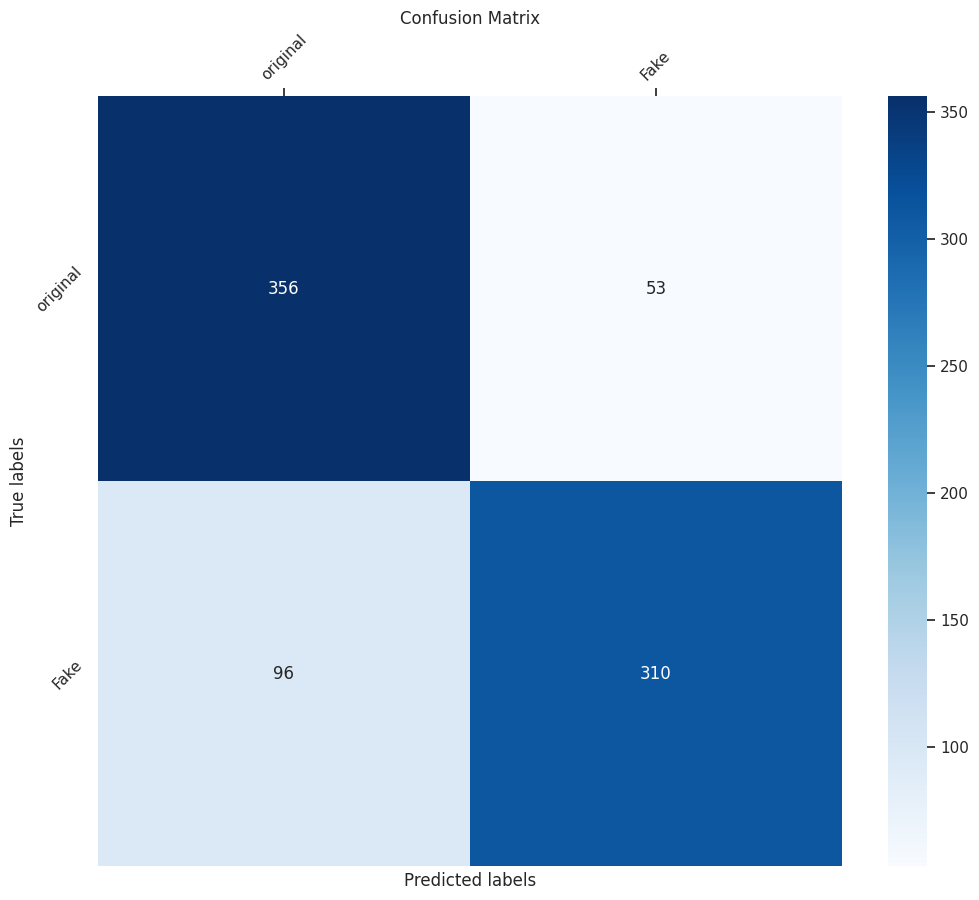

In [ ]:
def con_mat(model):
  test_prediction = np.argmax(model.predict(val_data), axis = -1)
  cm = confusion_matrix(val_labels, test_prediction)
  print(cm)

  import seaborn as sns
  #sns.set()
  plt.figure(figsize =(12, 10))
  ax = plt.subplot()
  sns.heatmap(cm, annot=True,fmt="d",cmap='Blues', ax = ax) #annot=True to annotate cells
  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(class_names, rotation=45); ax.yaxis.set_ticklabels(class_names, rotation=45);
  ax.xaxis.tick_top()

con_mat(cnn_lstm_model)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test.cleaned)
print(test_sequences[0:10])
test_data = keras.preprocessing.sequence.pad_sequences(test_sequences, value=0.0,
                                                      padding='post', maxlen= padding_length)

[[15173, 44, 4820, 125, 51], [47, 1245, 1551, 1017], [12989, 236, 9993, 3069, 1560, 10555, 43, 149, 134], [567, 12], [15794, 5012, 10156, 3881, 6238, 102], [569, 9802, 1031, 8, 19, 281, 224, 31, 824, 280, 537, 1882, 1538, 1810, 1031, 1448, 178, 426], [3862, 3863, 11108, 3864, 1094, 150, 805], [5, 83, 50, 139, 1991, 70, 2], [11, 321, 77, 1853], []]


In [ ]:
pred= np.argmax(cnn_lstm_model.predict(test_data), axis=-1)


32/32 [==============================] - 1s 17ms/step


In [ ]:
jongu = pd.DataFrame(pred, columns=['ll'])


In [ ]:
jongu


,ll
0,0
1,1
2,0
3,0
4,0
...,...
1014,1
1015,1
1016,0
1017,0


In [ ]:
test['label']= jongu.ll.replace({0:'original',1:'Fake'})


In [ ]:
test.head(15)


,text,cleaned,label
0,5000 ഉള്ള പോൾ ലോഗ്‌ഡ്‌വൻ ഇപ്പോള് 250000 എന്താ...,5000 ഉള്ള പോൾ ലോഗ്‌ഡ്‌വൻ ഇപ്പോള് 250000 എന്താ ...,original
1,ഓഷോ രജനീഷ് പറഞ്ഞപോലെ എനിക്കപ്പോൾ തോന്നിയത് അ...,ഓഷോ രജനീഷ് പറഞ്ഞപോലെ എനിക്കപ്പോൾ തോന്നിയത് അങ്...,Fake
2,ചേട്ടാ വാർത്ത വയ്ക്കുന്നത് കേരളത്തിലാണ് സം...,ചേട്ടാ വാർത്ത വയ്ക്കുന്നത് കേരളത്തിലാണ് സംഘി ഭ...,original
3,Shame for entire Woman&#39,shame entire woman #39,original
4,135 code janaghal andhu wide business cheythal...,135 code janaghal andhu wide business cheythal...,original
5,Why not all countries club together n block ch...,countries club together n block china maximum ...,Fake
6,Ethil appuram നാണക്കേഡ് വന്നിട്ടില്ല cpmne🤣🤣🤣a...,ethil appuram നാണക്കേഡ് വന്നിട്ടില്ല cpmne adi...,original
7,കൊറോണ പോയി ഒന്ന് കൂടെ മെച്ചപ്പെട്ട് ഓമൈക്രോനായ...,കൊറോണ പോയി ഒന്ന് കൂടെ മെച്ചപ്പെട്ട് ഓമൈക്രോനായ...,original
8,മോളെ. ഇത് കോമഡി സ്റ്റാർസ് അല്ല. ചിരിച്ചും കളിച...,മോളെ. ഇത് കോമഡി സ്റ്റാർസ് അല്ല. ചിരിച്ചും കളിച...,original
9,Marunaadan kandupidutham,marunaadan kandupidutham,original


In [ ]:
test = test[['text','label']]


In [ ]:
test

,text,label
0,5000 ഉള്ള പോൾ ലോഗ്‌ഡ്‌വൻ ഇപ്പോള് 250000 എന്താ...,original
1,ഓഷോ രജനീഷ് പറഞ്ഞപോലെ എനിക്കപ്പോൾ തോന്നിയത് അ...,Fake
2,ചേട്ടാ വാർത്ത വയ്ക്കുന്നത് കേരളത്തിലാണ് സം...,original
3,Shame for entire Woman&#39,original
4,135 code janaghal andhu wide business cheythal...,original
...,...,...
1014,Correct ...China cheitha ...weapon spread ing ...,Fake
1015,ഈ WHO പറയുന്നതനുസരിച്ചു ചികിത്സയും ലോക്ക് ഡൌൺ ...,Fake
1016,Mask illa aarkum😏😏,original
1017,ഇയാളെ കൊറോണ. രോഗി കൾ കിടയിൽ. ഇടാമായിരുന്നു---!!,original


In [ ]:
test.to_csv('Punny_Punctuators Task 1.csv', index=False)